In [1]:
import os
import sys

import gym
import eplus_env

import argparse
from numpy import genfromtxt
import numpy as np
import pickle
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


sys.path.append('../')
sys.path.append('../')
from diff_mpc import mpc
from diff_mpc.mpc import QuadCost, LinDx

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [2]:
seed = 42
lr = 5e-4
T = 12
step = 900
eta_int = 5
batch_size = 256
save_name = 'rl'

In [3]:
torch.manual_seed(seed)

# Modify here: Outputs from EnergyPlus; Match the variables.cfg file.
obs_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Htg SP", "Clg SP", "Indoor Temp.", "Indoor Temp. Setpoint", "PPD", "Occupancy Flag", "Coil Power", "HVAC Power", "Sys In Temp.", "Sys In Mdot", "OA Temp.", "OA Mdot", "MA Temp.", "MA Mdot", "Sys Out Temp.", "Sys Out Mdot"]

# Modify here: Change based on the specific control problem
state_name = ["Indoor Temp."]
dist_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# Caveat: The RL agent controls the difference between Supply Air Temp. and Mixed Air Temp., i.e. the amount of heating from the heating coil. But, the E+ expects Supply Air Temp. Setpoint.
ctrl_name = ["Delta T"]
target_name = ["Indoor Temp. Setpoint"]

n_state = len(state_name)
n_ctrl = len(ctrl_name)
n_dist = len(dist_name)

eta = [0.1, eta_int] # eta: Weight for comfort during unoccupied and occupied mode
step = step # step: Timestep; Unit in seconds
T = T # T: Number of timesteps in the planning horizon
tol_eps = 90 # tol_eps: Total number of episodes; Each episode is a natural day

# Read Historical Data
dataset = pd.read_pickle("simulation_results/Sim-TMY3.pkl") 
target = dataset[target_name]
disturbance = dataset[dist_name]
# Min-Max Normalization
disturbance = (disturbance-disturbance.min())/(disturbance.max()-disturbance.min())

dataset["Delta T"] = dataset["Sys Out Temp."]-dataset["MA Temp."]

# Train-Test Split
n_samples = len(dataset)
n_train = int(0.7*n_samples)
n_test = n_samples - n_train
train_set = dataset[:n_train]
test_set = dataset[n_train:]

In [4]:
class Learner():
    def __init__(self, n_state, n_ctrl, n_dist, disturbance, target, u_upper, u_lower):
        self.n_state = n_state
        self.n_ctrl = n_ctrl
        self.n_dist = n_dist
        self.disturbance = disturbance
        self.target = target
        
        # My Initial Guess
        self.F_hat = torch.ones((self.n_state, self.n_state+self.n_ctrl))
        self.F_hat[0, 0] = 0.9
        self.F_hat[0, 1] = 0.3
        self.F_hat = self.F_hat.double().requires_grad_()
        
        self.Bd_hat = np.random.rand(self.n_state, self.n_dist)
        self.Bd_hat = torch.tensor(self.Bd_hat).requires_grad_()
        
        self.optimizer = optim.Adam([self.F_hat, self.Bd_hat], lr=lr)
    
        self.u_lower = u_lower * torch.ones(T, 1, n_ctrl).double()
        self.u_upper = u_upper * torch.ones(T, 1, n_ctrl).double()
    
    def Cost_function(self, cur_time):
        diag = torch.zeros(T, self.n_state + self.n_ctrl)
        occupied = self.disturbance["Occupancy Flag"][cur_time:cur_time + pd.Timedelta(seconds = (T-1) * step)]
        occupied = np.array(occupied)
        if len(occupied)<T:
            occupied = np.pad(occupied, ((0, T-len(occupied)), ), 'edge')
        eta_w_flag = torch.tensor([eta[int(flag)] for flag in occupied]).unsqueeze(1).double() # Tx1
        diag[:, :n_state] = eta_w_flag
        diag[:, n_state:] = 0.001
        
        C = []
        for i in range(T):
            C.append(torch.diag(diag[i]))
        C = torch.stack(C).unsqueeze(1) # T x 1 x (m+n) x (m+n)
        
        x_target = self.target[cur_time : cur_time + pd.Timedelta(seconds = (T-1) * step)] # in pd.Series
        x_target = np.array(x_target)
        if len(x_target)<T:
            x_target = np.pad(x_target, ((0, T-len(x_target)), (0, 0)), 'edge')
        x_target = torch.tensor(x_target)
        
        c = torch.zeros(T, self.n_state+self.n_ctrl) # T x (m+n)
        c[:, :n_state] = -eta_w_flag*x_target
        c[:, n_state:] = 1 # L1-norm now! Check
        c = c.unsqueeze(1) # T x 1 x (m+n)
        return C, c
    
    def forward(self, x_init, C, c, cur_time):
        dt = np.array(self.disturbance[cur_time : cur_time + pd.Timedelta(seconds = (T-2) * step)]) # T-1 x n_dist
        if len(dt)<T-1:
            dt = np.pad(dt, ((0, T-1-len(dt)), (0, 0)), 'edge')
        dt = torch.tensor(dt).transpose(0, 1) # n_dist x T-1
        
        ft = torch.mm(self.Bd_hat, dt).transpose(0, 1) # T-1 x n_state
        ft = ft.unsqueeze(1) # T-1 x 1 x n_state
        
        x_pred, u_pred, _ = mpc.MPC(n_state=self.n_state,
                                    n_ctrl=self.n_ctrl,
                                    T=T,
                                    u_lower = self.u_lower,
                                    u_upper = self.u_upper,
                                    lqr_iter=20,
                                    verbose=0,
                                    exit_unconverged=False,
                                    )(x_init, QuadCost(C.double(), c.double()),
                                      LinDx(self.F_hat.repeat(T-1, 1, 1, 1),  ft))
        
        return x_pred[1, 0, :], u_pred[0, 0, :] # Dim.
    
    def predict(self, x_init, action, cur_time):
        dt = np.array(self.disturbance.loc[cur_time]) # n_dist
        dt = torch.tensor(dt).unsqueeze(1) # n_dist x 1
        ft = torch.mm(self.Bd_hat, dt) # n_state x 1
        tau = torch.stack([x_init, action]) # (n_state + n_ctrl) x 1
        next_state  = torch.mm(self.F_hat, tau) + ft # n_state x 1
        return next_state
                                    
    def update_parameters(self, x_true, u_true, x_pred, u_pred):
        # Every thing in T x Dim.
        state_loss = torch.mean((x_true.double() - x_pred)**2)
        action_loss = torch.mean((u_true.double() - u_pred)**2)
        
        # Note: eta balances the importance between predicting states and predicting actions
        traj_loss = eta_int*state_loss + action_loss
        print("From state {}, From action {}".format(state_loss, action_loss))
        self.optimizer.zero_grad()
        traj_loss.backward()
        self.optimizer.step()
#         print(self.F_hat)
#         print(self.Bd_hat)
        return state_loss.detach(), action_loss.detach()
        
def evaluate_performance(x_true, u_true, x_pred, u_pred):
    state_loss = torch.mean((x_true.double() - x_pred)**2)
    action_loss = torch.mean((u_true.double() - u_pred)**2)
    return state_loss, action_loss

In [7]:
def main():
    dir = 'results_offline_raw'
    if not os.path.exists(dir):
        os.mkdir(dir)
        
    if not os.path.exists('results_offline_raw/weights'):
        os.mkdir('results_offline_raw/weights')
    
    perf = []
    n_step = 96 # n_step: Number of Steps per Day
    numOfEpoches = 20
    
    timeStamp = []
    record_name =["Learner nState", "Expert nState", "Learner action", "Expert action"]
    losses = []
    losses_name = ["train_state_loss", "train_action_loss", "val_state_loss", "val_action_loss"]
    
    # Initialize the learner
    u_upper = 5
    u_lower = 0
    learner = Learner(n_state, n_ctrl, n_dist, disturbance, target, u_upper, u_lower)
     
    for epoch in range(numOfEpoches):
        x_true = []
        u_true = []
        x_pred = []
        u_pred = []
        
        train_state_loss = []
        train_action_loss = []
        for i in range(n_train): # By number of entries in the historical data
            idx = np.random.randint(n_train)
            cur_time = train_set.index[idx]
           
            expert_moves = train_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
            if len(expert_moves)<2:
                print(cur_time)
                continue
            
            expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
            expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
            x_true.append(expert_state[-1])
            u_true.append(expert_action[0])

            obs = train_set.loc[cur_time]
            x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # n_batch x n_state, i.e. 1 x n_state
            C, c = learner.Cost_function(cur_time)
            learner_state, learner_action = learner.forward(x_init, C, c, cur_time)
                
            # Predict next state based on expert's action
            next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
            x_pred.append(next_state)
            u_pred.append(learner_action)
            
            if (i % batch_size == 0) & (i>0):
                x_true = torch.stack(x_true).reshape(-1, n_state)
                u_true = torch.stack(u_true).reshape(-1, n_ctrl)
                x_pred = torch.stack(x_pred).reshape(-1, n_state)
                u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
                b_state_loss, b_action_loss = learner.update_parameters(x_true, u_true, x_pred, u_pred)
                train_state_loss.append(b_state_loss)
                train_action_loss.append(b_action_loss)
                x_true = []
                u_true = []
                x_pred = []
                u_pred = []

        # Evaluate performance at the end of each epoch
        x_true = []
        u_true = []
        x_pred = []
        u_pred = []
        timeStamp = []
        for idx in range(n_test):
            cur_time = test_set.index[idx]
            expert_moves = test_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
            if len(expert_moves)<2:
                print(cur_time)
                continue
            expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
            expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
            x_true.append(expert_state[-1])
            u_true.append(expert_action[0])
            
            timeStamp.append(cur_time+pd.Timedelta(seconds = step))
            
            obs = test_set.loc[cur_time]
            x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # 1 x n_state
            C, c = learner.Cost_function(cur_time)
            learner_state, learner_action = learner.forward(x_init, C, c, cur_time)
            next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
            x_pred.append(next_state.detach())
            u_pred.append(learner_action.detach())
            
        x_true = torch.stack(x_true).reshape(-1, n_state)
        u_true = torch.stack(u_true).reshape(-1, n_ctrl)
        x_pred = torch.stack(x_pred).reshape(-1, n_state)
        u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
        val_state_loss, val_action_loss = evaluate_performance(x_true, u_true, x_pred, u_pred)
        print("At Epoch {0}, the loss from the state is {1} and from the action is {2}".format(epoch, val_state_loss, val_action_loss))
        losses.append((np.mean(train_state_loss), np.mean(train_action_loss), val_state_loss, val_action_loss))
       
        record = pd.DataFrame(torch.cat((x_pred, x_true, u_pred, u_true), dim = 1).numpy(), index = np.array(timeStamp), columns = record_name)
        record_df = pd.DataFrame(np.array(record), index = np.array(timeStamp), columns = record_name)
        record_df.to_pickle("results_offline_raw/Imit_{}_{}.pkl".format(save_name, epoch))
        
        # Save weights
        F_hat = learner.F_hat.detach().numpy()
        Bd_hat = learner.Bd_hat.detach().numpy()
        np.save("results_offline_raw/weights/F-{}.npy".format(epoch), F_hat)
        np.save("results_offline_raw/weights/Bd-{}.npy".format(epoch), Bd_hat)
        
    # Save losses at each epoch
    losses_df = pd.DataFrame(np.array(losses), index = np.arange(numOfEpoches), columns = losses_name)
    losses_df.to_pickle("results_offline_raw/Imit_loss_"+save_name+".pkl")

In [8]:
main()

From state 0.46924287606250525, From action 4.7904760242130155
From state 0.50968098343135, From action 5.255283513649172
From state 0.5095233433198925, From action 4.235019484176057
From state 0.5208779177251736, From action 5.806777931852978
From state 0.47192829738493663, From action 5.13436136895071
From state 0.4693345580974575, From action 4.92007424126571
From state 0.5609129554523582, From action 4.320762281691396
From state 0.46930844400589056, From action 4.806253896719301
From state 0.4809220567684565, From action 5.003930505529064
From state 0.42173102291703246, From action 4.590763473376983
From state 0.45958219650169846, From action 4.577937241893306
From state 0.43120603519132694, From action 5.0288459492458975
From state 0.41642240276222464, From action 4.401351481167717
From state 0.53415559542564, From action 4.730872136443001
From state 0.5203499942184682, From action 5.268613072091695
From state 0.5298491113116486, From action 5.426158536721277
From state 0.48364825

From state 0.4016567127186892, From action 5.097690654744476
From state 0.3522166480929987, From action 4.193111162075306
From state 0.4123410492976468, From action 5.640513601056332
From state 0.4194694808748329, From action 4.871292767414485
From state 0.4715130483137834, From action 4.174213869910247
From state 0.41711762276076814, From action 5.096047779739696
From state 0.31241741023546055, From action 4.644408457459021
From state 0.42300052535692, From action 5.617191454960823
From state 0.36942242831899197, From action 4.443096146000511
From state 0.3665350933031536, From action 5.177595312146363
From state 0.3929951467022607, From action 3.624421782779657
From state 0.4044443539162885, From action 4.644013566188953
From state 0.41197808665146346, From action 5.131853743687904
From state 0.4185105528477142, From action 4.859861615291479
From state 0.4721944684739374, From action 4.974649732772011
From state 0.3259723666104607, From action 4.006656400186737
1991-04-02 00:00:00
At

From state 0.34999573684650254, From action 4.647848249585753
From state 0.32852452934704934, From action 3.855034422060128
From state 0.3166767761341561, From action 3.611106018888792
From state 0.3432899209399221, From action 3.9104680943099894
From state 0.3622995433634972, From action 3.8871755746258847
From state 0.37505315837844566, From action 4.513477719389385
1991-03-05 16:30:00
From state 0.3726888863458691, From action 4.702719133405314
From state 0.3330576861625095, From action 5.032856758721628
From state 0.3447851745585553, From action 4.323649960587285
From state 0.36516251344815365, From action 4.6145226007245
From state 0.29725289229953433, From action 4.806834273807074
From state 0.31324373707630987, From action 4.217193472421874
1991-03-05 16:30:00
From state 0.3423897091360519, From action 5.400023785103355
From state 0.338402853283444, From action 4.5901454010078595
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping throug

From state 0.2796741619789472, From action 4.456969012672168
From state 0.2529076572549578, From action 4.484668349518439
From state 0.24492197731443213, From action 3.881509448060416
From state 0.2654460304128823, From action 3.95602979884932
From state 0.2602020195198236, From action 4.088755467948881
1991-03-05 16:30:00
From state 0.21811840065856983, From action 4.152003528310378
From state 0.2569792345185914, From action 4.072869594189921
From state 0.2696230181900116, From action 4.797508249435394
From state 0.29709030661616764, From action 4.303462781252619
From state 0.29149712454342736, From action 4.097809682186295
From state 0.34442935015240284, From action 4.093637038952814
1991-04-02 00:00:00
At Epoch 15, the loss from the state is 0.18359909112041592 and from the action is 2.040816218981596
From state 0.2889093588527532, From action 4.179259449191866
From state 0.2560372901259647, From action 4.285794589317204
From state 0.297860140582473, From action 4.3912991884404535
F

# Plots

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

Text(0.5,0,'Number of Epoches')

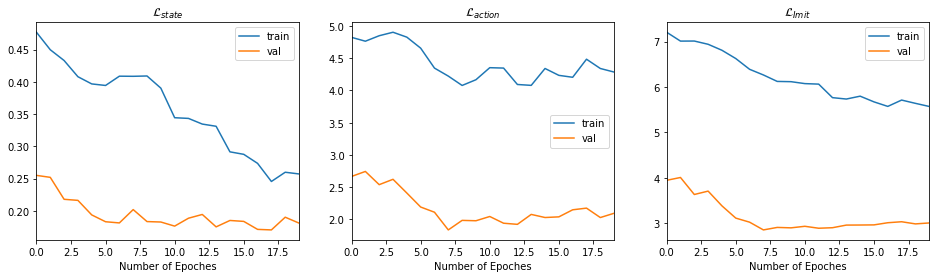

In [15]:
results_dir = 'results_offline_raw'
filePath = "{}/".format(results_dir)
lam = 5 
imit_loss = pd.read_pickle(filePath+"Imit_loss_rl.pkl")

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("$\mathcal{L}_{state}$")
plt.plot(imit_loss["train_state_loss"], label="train")
plt.plot(imit_loss["val_state_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,2)
plt.title("$\mathcal{L}_{action}$")
plt.plot(imit_loss["train_action_loss"], label="train")
plt.plot(imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,3)
plt.title("$\mathcal{L}_{Imit}$")
plt.plot(lam* imit_loss["train_state_loss"]+ imit_loss["train_action_loss"], label="train")
plt.plot(lam* imit_loss["val_state_loss"]+imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

In [24]:
# Selected Epoch
epoch = 16
imit_record = pd.read_pickle(filePath+"Imit_rl_{}.pkl".format(epoch))

imit_record["Hour"] = pd.Series([time.hour for time in imit_record.index], index = imit_record.index)
imit_record["Occupancy Flag"] = (imit_record["Hour"]>=8) & (imit_record["Hour"]< 18)
imit_record["Indoor Temp. Setpoint"] = pd.Series([22.5 if occupied==1 else 12.8 for occupied in imit_record["Occupancy Flag"]], index = imit_record.index)

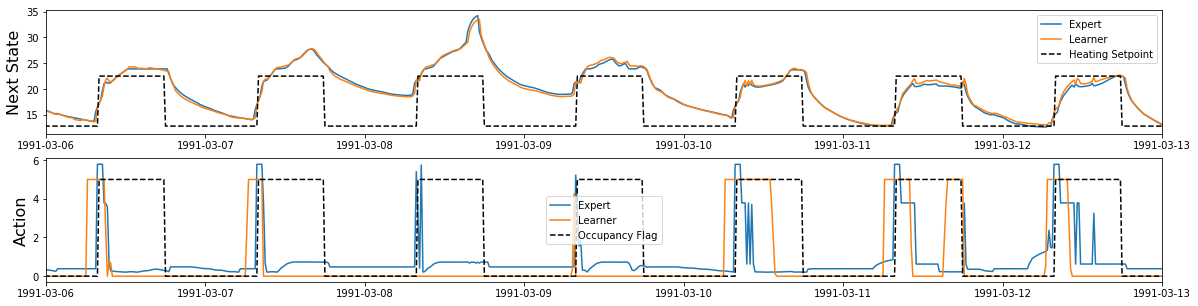

In [23]:
start_time = pd.datetime(year = 1991, month = 3, day = 6)
end_time = start_time + pd.Timedelta(days = 7)

fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(imit_record["Expert nState"], label = "Expert")
plt.plot(imit_record["Learner nState"], label = "Learner")
plt.plot(imit_record["Indoor Temp. Setpoint"], "k--", label = "Heating Setpoint")
plt.ylabel("Next State", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

plt.subplot(2,1,2)
plt.plot(imit_record["Expert action"], label = "Expert")
plt.plot(imit_record["Learner action"], label = "Learner")
plt.plot(imit_record["Occupancy Flag"]*5, 'k--', label = "Occupancy Flag")
plt.ylabel("Action", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()